# Slow feature analysis

### Background

Slow feature analysis (SFA) is a optimization that extracts the slowest-moving features of the signal
![missing image, need to be connected to internet](http://scholarpedia.org/w/images/thumb/c/c5/SlowFeatureAnalysis-SlownessPrinciple.jpeg/400px-SlowFeatureAnalysis-SlownessPrinciple.jpeg "")


![missing image of steps of SFA](http://scholarpedia.org/w/images/thumb/d/df/SlowFeatureAnalysis-Algorithm.png/800px-SlowFeatureAnalysis-Algorithm.png "")

## Sine wave example

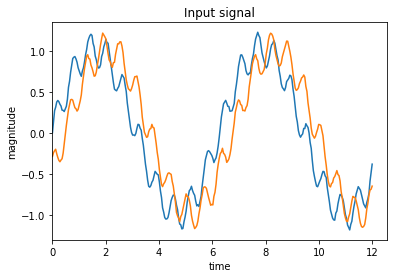

In [26]:
import numpy as np
import matplotlib.pyplot as plt
start = 0
end = 12
nsamples = 300
x = np.linspace(start,end, nsamples)
shift = 0.5
twoD = True
signal = np.sin(x)+0.2*np.sin(10*x)+0.05*np.random.random(x.shape)
if twoD:
    signal_shifted = np.sin(x-shift)+0.2*np.sin(10*(x-shift))+0.05*np.random.random(x.shape)
    signal = np.hstack([signal.reshape(-1,1), signal_shifted.reshape(-1,1)])
#scale to have mean 0 var 1, just for comparison purposes
rescaled_signal = (signal - np.mean(signal, 0)) / np.std(signal, 0)

plt.plot(x,signal)
plt.xlabel("time")
plt.ylabel("magnitude")
plt.title("Input signal")
plt.xlim([0,4*np.pi])
plt.show()

In [27]:
import mdp

'''
@param signal_list n x m array with n points in time that are m dimensional
'''
lookback = 3

def train_sfa(signal_list, degree=2, lookback=3):
    #put into format where columns are variables and rows are observations
    ndims = signal_list.shape[1]
    flow = (mdp.nodes.EtaComputerNode() +
        mdp.nodes.TimeFramesNode(lookback) +
        mdp.nodes.PolynomialExpansionNode(degree) +
        mdp.nodes.PCANode(reduce=True)+ 
        mdp.nodes.SFANode(output_dim=ndims,include_last_sample=True) +
        mdp.nodes.EtaComputerNode() )
    flow.train(signal_list)
    return flow



(300, 2)


(0, 12.566370614359172)

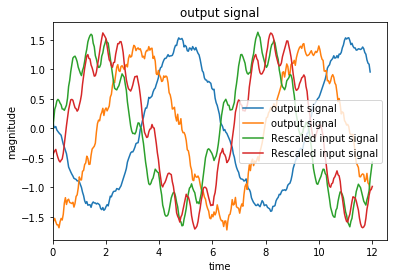

In [28]:
print(signal.shape)
trained_system = train_sfa(signal)
encoded = trained_system(signal)

plt.plot(x[:-lookback+1],encoded, label = "output signal")
plt.plot(x, rescaled_signal, label="Rescaled input signal")
plt.xlabel("time")
plt.ylabel("magnitude")
plt.title("output signal")
plt.legend()
plt.xlim([0,4*np.pi])

covariance between the output signal and the rescaled input signal
eta is a measure of the slowness. The lower the value the higher the slowness

In [29]:
print("Covariance", mdp.utils.cov2(rescaled_signal[:-lookback+1], encoded))
print("eta input", trained_system[0].get_eta(t=len(signal)))

print("eta output", trained_system[-1].get_eta(t=len(signal)-lookback))

Covariance [[-0.97704289 -0.16444105]
 [-0.93728647  0.32190181]]
eta input [4.30280798 4.34047041]
eta output [2.52820582 4.11247993]


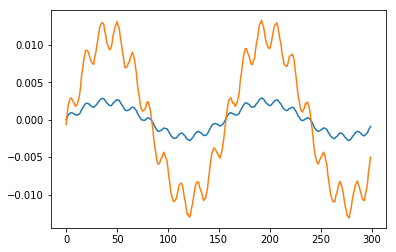

In [30]:
from scipy.signal import butter, lfilter, freqz
order = 2
fs = nsamples/(end-start)
cutoff = 0.4

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
y = butter_lowpass_filter(data=signal, cutoff=cutoff, fs=fs, order=order)
plt.plot(y)

In [31]:
## SFA on a 2D image activations

In [32]:
import numpy as np
from IPython.display import HTML
"""
moves at a constant velocity magnitude where direction changes randomly every time it hits a wall
"""
def generate_video(ndim=4, nframes=60, velocity_magnitude=0.3, noise_magnitude=0.2):
    grid_over_time = np.zeros((ndim,ndim, nframes))
    pose = [0,0]
    theta = 2*np.pi*np.random.random()
    for i in range(nframes):
        new_pose = [pose[0]+velocity_magnitude*np.cos(theta),pose[1]+velocity_magnitude*np.sin(theta)]
        new_rounded_pose = np.round(new_pose).astype(int)
        if (new_rounded_pose >= ndim*np.ones_like(pose)).any() or (new_rounded_pose < np.zeros_like(pose)).any():
            theta = 2*np.pi*np.random.random()
        else:
            pose = new_pose
        rounded_pose = np.round(pose).astype(int)
        grid = np.zeros((ndim, ndim))
        try:
            grid[rounded_pose[0], rounded_pose[1]]=1
        except:
            import ipdb; ipdb.set_trace()
        grid += noise_magnitude*np.random.random(grid.shape)
        grid *= 2
        grid_over_time[:,:,i] = grid
    return grid_over_time

def play_video(video, deflatten=False, xlabel="", ylabel="", title = ""):
    import matplotlib.cm as cm
    import matplotlib.animation as animation
    frames = [] # for storing the generated images
    fig = plt.figure()
     
    if deflatten:
        size = int(np.sqrt(video.shape[0]))
        video_to_play = video.reshape((size, size, video.shape[1]))
    else:
        video_to_play = video
    for i in range(video_to_play.shape[2]):
        im = plt.imshow(video_to_play[:,:,i],cmap='gray',animated=True)
        frames.append([im])
    ani = animation.ArtistAnimation(fig, frames, interval=400, blit=True,
                                    repeat_delay=1000)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.close()
    return HTML(ani.to_html5_video())

        
video = generate_video()
play_video(video, title="Box moving around cinematic version")

In [ ]:
from PIL import Image
input_signal = video.reshape(video.shape[2],video.shape[0]*video.shape[1])
trained_system = train_sfa(input_signal) 
print(trained_system[0].get_eta(t=100))

encoded = trained_system(input_signal)
play_video(encoded.T, deflatten=True, xlabel = "output dim", ylabel= "time", title = "encoding visualization")

[10.82102725  9.88488016  9.53558425 11.15552641 11.50750131 11.61803541
 11.95985751 11.50871366 10.96942887 10.64216449 11.36882482 11.65617367
 11.61737546 12.01525099 11.29980507 11.15104624]


In [12]:
encoded_second = trained_system(encoded)
play_video(encoded_second.T, deflatten=True, xlabel = "output dim", ylabel= "time", title = "encoding 2x visualization")

Assuming square video...


In [23]:
N = 7
encoded_new = encoded_second[:]
for i in range(N):
    encoded_new = trained_system(encoded_new)
play_video(encoded_new.T, deflatten=True, title = "encoding Nx visualization")

FlowExceptionCR: 
----------------------------------------
! Exception in node #0 (EtaComputerNode):
Node Traceback:
Traceback (most recent call last):
  File "/home/lagrassa/virtualenvs/test/lib/python3.5/site-packages/mdp/linear_flows.py", line 348, in _execute_seq
    x = flow[i].execute(x)
  File "/home/lagrassa/virtualenvs/test/lib/python3.5/site-packages/mdp/signal_node.py", line 646, in execute
    self._pre_execution_checks(x)
  File "/home/lagrassa/virtualenvs/test/lib/python3.5/site-packages/mdp/signal_node.py", line 524, in _pre_execution_checks
    self._check_input(x)
  File "/home/lagrassa/virtualenvs/test/lib/python3.5/site-packages/mdp/signal_node.py", line 480, in _check_input
    raise NodeException(error_str)
mdp.NodeException: x has dimension 16, should be 2
----------------------------------------

In [25]:

slownesses = trained_system[0].get_eta(t=500).reshape(video.shape[0:2])
plt.title("The slower the gridsquare, the darker the square in this graph")
plt.imshow(slownesses*255, cmap="gray")
play_video(video, title="original cinematic version")

ValueError: cannot reshape array of size 2 into shape (4,4)